# Data

Let's have a look at the data first

In [1]:
import os
from pathlib import Path

input_data_path = Path(os.environ.get('INPUT_DATA_PATH', '.'))
output_data_path = Path(os.environ.get('OUTPUT_DATA_PATH', '.'))

train_file = str(input_data_path / "data_train.npz")
test_file = str(input_data_path / "data_test.npz")
prediction_file = str(output_data_path / "data_test_prediction.npz")


if not (os.path.isfile(train_file) and
        os.path.isfile(test_file)):
    if not os.path.isfile("input_public_data.zip"):
        !wget https://codalab.coresearch.club/my/datasets/download/37304c34-1d4a-4f43-bcb2-1fdeb37c5cba -O input_public_data.zip
    !unzip -n input_public_data.zip

In [2]:
import numpy as np

In [3]:
data_real = np.load(train_file, allow_pickle=True)

# This is the calorimeter response:
energy = data_real['EnergyDeposit']

# These are the quantities we want to predict
momentum = data_real['ParticleMomentum'][:,:2]
coordinate = data_real['ParticlePoint'][:,:2]

In [4]:
print('energy.shape:', energy.shape)
print('momentum.shape:', momentum.shape)
print('coordinate.shape:', coordinate.shape)

energy.shape: (9916, 30, 30)
momentum.shape: (9916, 2)
coordinate.shape: (9916, 2)


So, we have images of 30x30 pixels and we want to predict 4 numbers for each of them: x, y, px and py.

Let's have a look at some of the images

In [5]:
import matplotlib.pyplot as plt

In [6]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(10, 10, hspace=0.01, wspace=0.01)

# print(energy.min(), energy.max())
MEAN = energy.mean()
STD = energy.std()
print(f"mean: {MEAN}")
print(f"std: {STD}")

#for i in range(100):
#    r = np.random.randint(len(energy))
#    img = energy[r]
#    ax = plt.subplot(gs[i])
#    ax.imshow(img, vmin=energy.min(), vmax=energy.max())
#    ax.set_xticks([])
#    ax.set_yticks([])
#    ax.set_xticklabels([])
#    ax.set_yticklabels([])

mean: 3.337254797777628
std: 24.675131863918715


<Figure size 1080x1080 with 0 Axes>

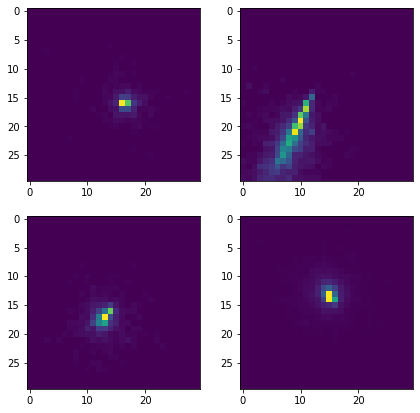

In [7]:
plt.figure(figsize=(7, 7))
plt.subplot(221)
plt.imshow(energy[5])
plt.subplot(222)
plt.imshow(energy[50])
plt.subplot(223)
plt.imshow(energy[500])
plt.subplot(224)
plt.imshow(energy[5000]);

It's also worth knowing how the targets are distributed:

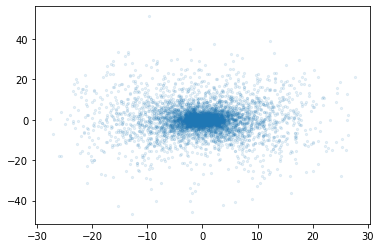

In [8]:
plt.scatter(*momentum.T, s=5, alpha=0.1);

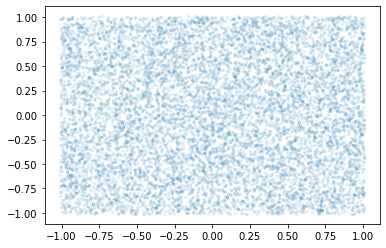

In [9]:
plt.scatter(*coordinate.T, s=5, alpha=0.1);

Naive approach: can we predict the coordinates from the center of mass position of the calorimeter response?

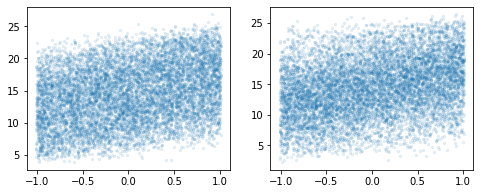

In [10]:
energy_density = energy / energy.sum(axis=(1, 2), keepdims=True)

cell_coords = np.stack([*np.meshgrid(
    np.arange(energy.shape[1]),
    np.arange(energy.shape[2])
)], axis=-1)[None,...]

center_of_mass = (energy_density[...,None] * cell_coords).sum(axis=(1, 2))

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.scatter(coordinate[:,0], center_of_mass[:,0], s=5, alpha=0.1)
plt.subplot(122)
plt.scatter(coordinate[:,1], center_of_mass[:,1], s=5, alpha=0.1);

Looks like the correlation isn't too strong. Maybe higher moments would give us a better picture, but we'll leave such experiments to you.

# Example solution

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim

from IPython.display import clear_output
# from tqdm.notebook import tqdm
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [12]:
X = energy[:,None,...] # adding Channels dimension
X = (X - MEAN)/STD
Y = np.concatenate([coordinate, momentum], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(8428, 1, 30, 30) (8428, 4) (1488, 1, 30, 30) (1488, 4)


In [13]:
def make_torch_dataset(X, Y, batch_size, shuffle=True):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    ds = utils.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(
        ds, batch_size=batch_size,
        pin_memory=True, shuffle=shuffle
    )

BATCH_SIZE = 64

ds_train = make_torch_dataset(X_train, Y_train, BATCH_SIZE)
ds_val = make_torch_dataset(X_val, Y_val, BATCH_SIZE, shuffle=False)

In [14]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(4)
        self.fc = nn.Linear(256, 256)
        self.head = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        #out = F.dropout(out, 0.1)
        out = self.fc(out)
        #out = F.dropout(out, 0.1)
        out = self.head(out)
        
        return out

In [15]:
device = torch.device('cuda:0')
# device = torch.device('cpu:0')
device

device(type='cuda', index=0)

In [16]:
# TODO: split momentum and coordinates in two independent models
# not sure it helps, the fully connected layer should be able to learn the different scale
regressor = ResNet(ResidualBlock, [3, 3, 3], num_classes=4).to(device)

In [17]:
def metric_relative_mse(y_true, y_pred):
    return (
        (y_true - y_pred).pow(2).mean(dim=0) / y_true.pow(2).mean(dim=0)
    )

def metric_relative_mse_total(y_true, y_pred):
    return metric_relative_mse(y_true, y_pred).sum()

In [18]:
opt = optim.Adam(regressor.parameters(), lr=1e-3, weight_decay=1e-3)
loss_fn = torch.nn.MSELoss().to(device)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.9, verbose=True)
epochs = 300
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[200, 250], gamma=0.1)

In [19]:
def run_training(epochs=5):
    losses_train = []
    losses_val = []
    metrics_train = []
    metrics_val = []
    per_component_metrics_train = []
    per_component_metrics_val = []

    t = tqdm(range(epochs))
    for epoch in t:
        regressor.train()
        for batch_X, batch_Y in ds_train:
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            pred = regressor(batch_X)
            loss = loss_fn(pred, batch_Y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses_train.append(loss.item())
            metrics_train.append(
                metric_relative_mse_total(batch_Y, pred).item()
            )

            per_component_metrics_train.append(
                metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
            )

        avg_loss, avg_metrics, avg_per_component_metrics = [], [], []
        regressor.eval()
        with torch.no_grad():
            for batch_X, batch_Y in ds_val:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

                pred = regressor(batch_X)
                loss = loss_fn(pred, batch_Y)

                avg_loss.append(loss.item())
                avg_metrics.append(
                    metric_relative_mse_total(batch_Y, pred).item()
                )
                avg_per_component_metrics.append(
                    metric_relative_mse(batch_Y, pred).detach().cpu().numpy()
                )
        losses_val.append(np.mean(avg_loss))
        metrics_val.append(np.mean(avg_metrics))
        per_component_metrics_val.append(
            np.mean(avg_per_component_metrics, axis=0)
        )
        
        scheduler.step()
        t.set_description(f'loss: {np.mean(avg_loss):.2}, metrics: {np.mean(avg_metrics):.2}')
        t.refresh()
        
        clear_output(wait=True)
        plt.figure(figsize=(18, 4.5))

        plt.subplot(131)

        plt.title("Loss")
        plt.plot(losses_train, label='train')
        plt.plot(
            np.linspace(0, len(losses_train), len(losses_val), endpoint=False),
            losses_val, label='val'
        )
        plt.legend()

        plt.subplot(132)

        plt.title("Metric (per component)")
        ms_train = np.array(per_component_metrics_train).T
        ms_val = np.array(per_component_metrics_val).T
        for i, (m_train, m_val, color) in enumerate(zip(ms_train,
                                                        ms_val,
                                                        plt.rcParams['axes.prop_cycle'])):
            plt.plot(m_train, label=f'train (component {i})', c=color['color'])
            plt.plot(
                np.linspace(0, len(m_train), len(m_val), endpoint=False),
                m_val, '--', label=f'val (component {i})', c=color['color']
            )
        # plt.ylim(0, 1)
        plt.legend()

        plt.subplot(133)

        plt.title("Metric (total)")
        plt.plot(metrics_train, label='train')
        plt.plot(
            np.linspace(0, len(metrics_train), len(metrics_val), endpoint=False),
            metrics_val, label='val'
        )
        # plt.ylim(0, 1)
        plt.legend()
        plt.show()

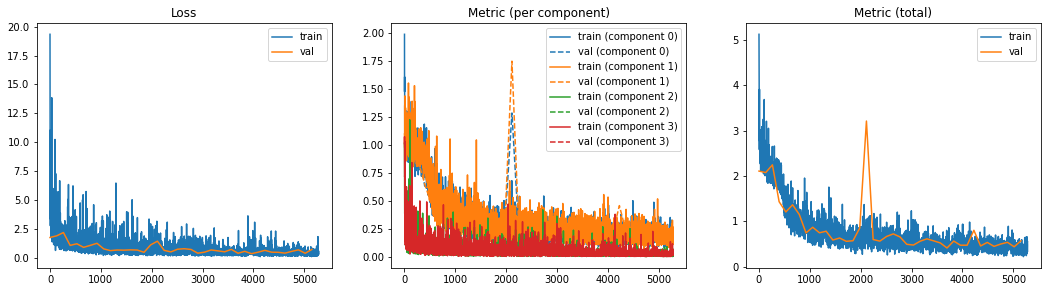

loss: 0.71, metrics: 0.57:  13%|█▎        | 40/300 [02:18<14:56,  3.45s/it]

In [ ]:
run_training(epochs)

In [ ]:
data_test = np.load(test_file, allow_pickle=True)
X_test = data_test['EnergyDeposit'][:,None,...]

In [ ]:
regressor.eval()
with torch.no_grad():
    prediction_test = regressor(torch.tensor(X_test, device=device).float()).cpu()

In [ ]:
coordinate_test, momentum_test = (
    prediction_test.detach().numpy()[:, :2],
    prediction_test.detach().numpy()[:, 2:],
)

In [ ]:
np.savez_compressed(prediction_file,
                    ParticlePoint=coordinate_test,
                    ParticleMomentum=momentum_test)